In [6]:
from transformers import pipeline

import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random

Segmentation Models: using `keras` framework.


In [80]:
import torch.nn.functional as F

In [2]:
model = pipeline('depth-estimation')

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


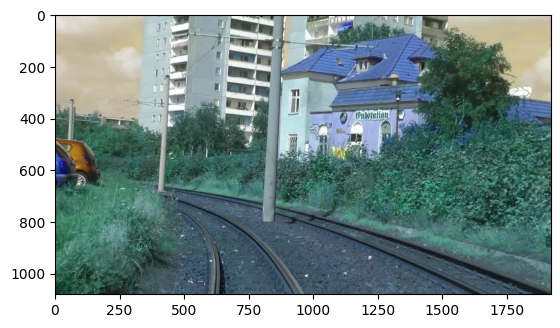

In [7]:
temp_img = cv2.imread('../rs19_val/jpgs/rs19_val/rs00062.jpg') #3 channels but all same. 
plt.imshow(temp_img) #Check for each channel. All chanels are identical

In [11]:
depth = model('../rs19_val/jpgs/rs19_val/rs00062.jpg')

In [19]:
depth['predicted_depth'].shape

torch.Size([1, 384, 384])

In [21]:
p_depth = depth['predicted_depth'].permute(1,2,0)

In [22]:
p_depth.shape

torch.Size([384, 384, 1])

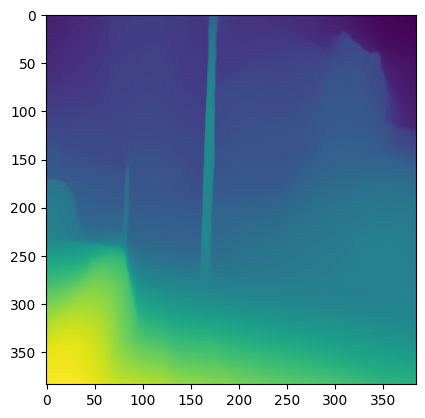

In [23]:
plt.imshow(p_depth)

In [24]:
def show_depth(path):
    depth = model(path)
    plt.imshow(depth['predicted_depth'].permute(1,2,0))

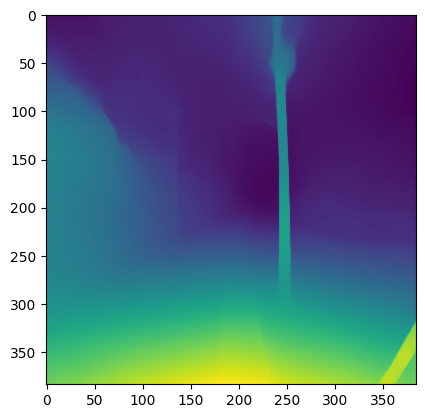

In [27]:
show_depth('../rs19_val/jpgs/rs19_val/rs00000.jpg')

../rs19_val/jpgs/rs19_val/rs00000.jpg
../rs19_val/jpgs/rs19_val/rs00001.jpg
../rs19_val/jpgs/rs19_val/rs00003.jpg
../rs19_val/jpgs/rs19_val/rs00004.jpg


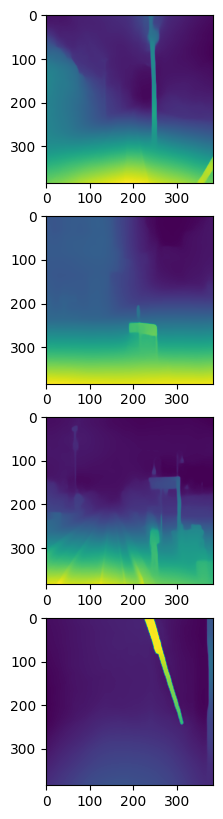

In [41]:
list_to_show = ['rs00000', 'rs00001', 'rs00003', 'rs00004']

#subplot(r,c) provide the no. of rows and columns
f, axis_arr = plt.subplots(4,1, figsize=(40,10)) 


for i in range(len(list_to_show)):
    path='../rs19_val/jpgs/rs19_val/'+list_to_show[i]+'.jpg'
    print(path)
    depth = model(path)
    axis_arr[i].imshow(depth['predicted_depth'].permute(1,2,0))

# Standard depth estimation

In [65]:
depest = pipeline('depth-estimation')
path = '../rs19_val/jpgs/rs19_val/rs00230.jpg'
path_processed = '../rs19_val/processed/rs00230_p.jpg'

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


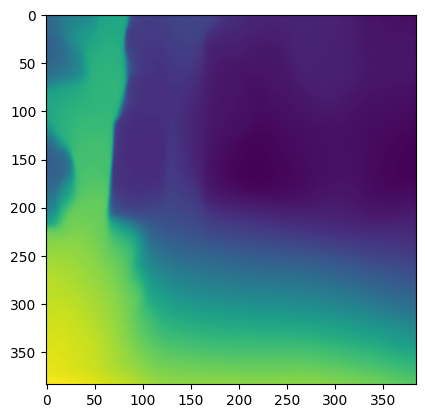

In [84]:
image = Image.open(path)
image = image.resize((256,256),3)
image.save(path_processed)
plt.imshow(image)
depth = model(path_processed)['predicted_depth'].permute(1,2,0)

plt.imshow(depth)

In [78]:
depth.shape

torch.Size([384, 384, 1])

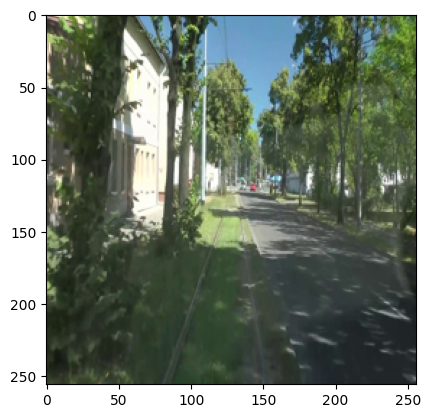

In [68]:
image = Image.open(path)
image = image.resize((256,256),3)
image.save(path_processed)
plt.imshow(image)

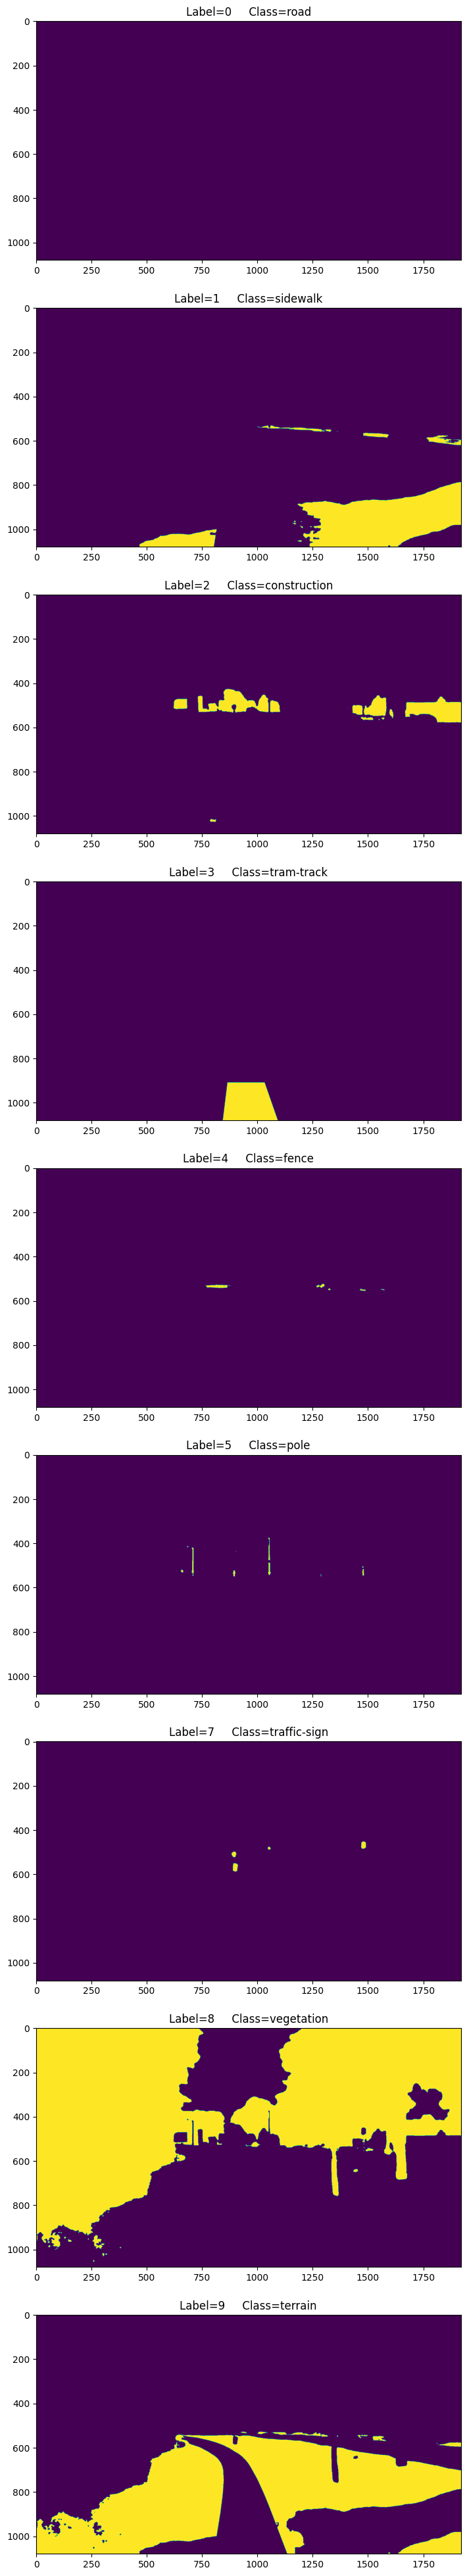

In [74]:
CLASSES = ['road',
        'sidewalk',
        'construction',
        'tram-track',
        'fence',
        'pole',
        'traffic-light',
        'traffic-sign',
        'vegetation',
        'terrain',
        'sky',
        'human',
        'rail-track',
        'car',
        'truck',
        'trackbed',
        'on-rails',
        'rail-raised',
        'rail-embedded']

#print one image per label class
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 ) = plt.subplots(9, figsize=(100,50))
cls = 0
for  ax in fig.get_axes():
    temp_mask = cv2.imread('../rs19_val/uint8/rs19_val/rs00627.png') 
    labels, count = np.unique(temp_mask[:,:,0], return_counts=True) 
    #this means that if the pixel labels are NOT the ones we care, make them all ZERO
    temp_mask[:,:,0][temp_mask[:,:,0]!=labels[cls]]=0
    ax.imshow(temp_mask[:,:,0]) 
    ax.title.set_text(f'Label={labels[cls]}     Class={CLASSES[labels[cls]]}')
    cls+= 1

In [85]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

In [95]:
# from transformers import DPTFeatureExtractor, DPTForDepthEstimation
# import torch
# import numpy as np
# from PIL import Image
# import requests


image = Image.open(path_processed)

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


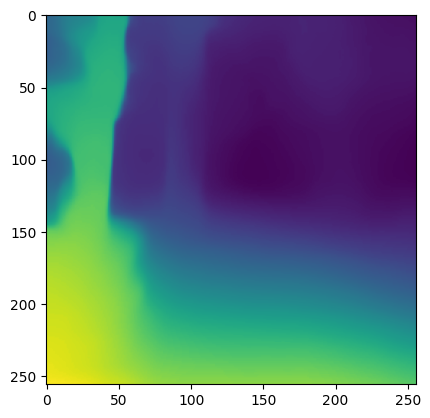

In [96]:
plt.imshow(depth)

In [133]:
depth_array = np.array(depth)

In [139]:
depth_array[0,250]

58

In [100]:
depth_array.shape

(256, 256)

In [99]:
depth_array

array([[117, 118, 119, ...,  57,  56,  56],
       [118, 118, 119, ...,  57,  57,  57],
       [118, 118, 118, ...,  58,  58,  57],
       ...,
       [251, 252, 251, ..., 199, 199, 199],
       [253, 253, 253, ..., 200, 200, 199],
       [255, 253, 253, ..., 202, 201, 200]], dtype=uint8)

In [103]:
depth_array.min()

50

In [106]:
unique, counts = np.unique(depth_array, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  50   44]
 [  51  403]
 [  52  641]
 [  53  704]
 [  54  720]
 [  55  877]
 [  56  906]
 [  57 1087]
 [  58 1334]
 [  59 1789]
 [  60 1504]
 [  61 1491]
 [  62 1647]
 [  63 1005]
 [  64  838]
 [  65  838]
 [  66  842]
 [  67  872]
 [  68 1082]
 [  69  920]
 [  70  816]
 [  71  389]
 [  72  307]
 [  73  299]
 [  74  376]
 [  75  607]
 [  76  686]
 [  77  722]
 [  78  789]
 [  79  711]
 [  80  673]
 [  81  553]
 [  82  512]
 [  83  470]
 [  84  477]
 [  85  477]
 [  86  499]
 [  87  445]
 [  88  386]
 [  89  358]
 [  90  345]
 [  91  345]
 [  92  332]
 [  93  231]
 [  94  209]
 [  95  212]
 [  96  189]
 [  97  184]
 [  98  173]
 [  99  189]
 [ 100  176]
 [ 101  177]
 [ 102  177]
 [ 103  168]
 [ 104  171]
 [ 105  162]
 [ 106  160]
 [ 107  168]
 [ 108  159]
 [ 109  156]
 [ 110  183]
 [ 111  185]
 [ 112  200]
 [ 113  205]
 [ 114  211]
 [ 115  208]
 [ 116  216]
 [ 117  214]
 [ 118  223]
 [ 119  236]
 [ 120  216]
 [ 121  218]
 [ 122  213]
 [ 123  218]
 [ 124  203]
 [ 125  209]
 [ 126  201]

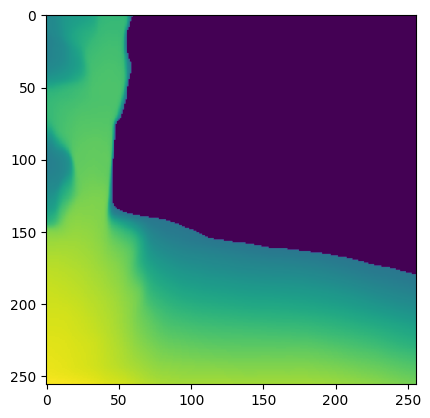

In [152]:
# careful with numpy copy
# https://numpy.org/doc/stable/reference/generated/numpy.copy.html
depth_array_processed = np.copy(depth_array)
depth_array_processed[depth_array_processed<100]=0
plt.imshow(depth_array_processed)

In [132]:
type(depth_array)

numpy.ndarray

In [154]:
formatted.shape

(256, 256)